In [3]:
!pip3 install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 511.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 5.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 11.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 16.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: idna
    Found existing installation: idna 3.3
    Uninstalling idna-3.3:
      Successfully uninstalled idna-3.3
  Attempting uninstall: chardet
    Found existing installation: chardet 5.0.0
    Uninstalling chardet-5.0.0

In [4]:
import os
from tqdm import tqdm
from d2l import torch as d2l

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

In [5]:
data_dir = r'/kaggle/input'
dataset_name = r'styletransfertest'
data_list = os.listdir(os.path.join(data_dir, dataset_name))

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
style_img = os.path.join(data_dir, dataset_name, data_list[1])
raw_img = os.path.join(data_dir, dataset_name, data_list[0])

rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])
_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=rgb_mean, std=rgb_std)
])

def load_img(img_dir):
    image = Image.open(img_dir)
    image = _transform(image).unsqueeze(0) #fake batch_size dim
    return image.to(device)

def back_to_PIL(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return transforms.ToPILImage()(img.permute(2, 0, 1))
style_img = load_img(style_img)
raw_img = load_img(raw_img)
print(style_img.size(), raw_img.size())

cuda
torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


In [18]:
'''
class content_loss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
    
class style_loss(nn.Module): #gram matrix and compute loss
    def __init__(self, feature_map):
        super().__init__()
        self.feature_map = self.gram_matrix(feature_map.detach())
    def gram_matrix(self, fm):
        b, c, h, w = fm.size()
        ch, n = b * c, h * w
        fm = fm.view(ch, n)
        gm = torch.mm(fm, fm.t())
        return gm
    def forward(self, input):
        self.loss = F.mse_loss(self.gram_matrix(input), self.feature_map)
        return input
    
    
class tv_loss(nn.Module):
    pass
'''
def content_loss(Y_hat, Y):
    return F.mse_loss(Y_hat, Y.detach())
def gram(fm):
    b, c, h, w = fm.size()
    ch, n = b * c, h * w
    fm = fm.view(ch, n)
    gm = torch.mm(fm, fm.t())
    return gm
def style_loss(Y_hat, Y):
    return F.mse_loss(gram(Y_hat), gram(Y.detach()))
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [19]:
backbone = models.vgg19(pretrained = True)
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
backbone = nn.Sequential(*[
    backbone.features[i]
    for i in range(max(content_layers + style_layers) + 1)]).to(device)
def extract_features(x, net, style, content):
    style_feature_map = []
    content_feature_map = []
    for i in range(len(net)):
        x = net[i](x)
        if i in style:
            style_feature_map.append(x)
        if i in content:
            content_feature_map.append(x)
    return style_feature_map, content_feature_map

def get_styles(style_img, backbone, style_layers, content_layers):
    return extract_features(style_img, backbone, style_layers, content_layers)[0]
def get_contents(content_img, backbone, style_layers, content_layers):
    return extract_features(content_img, backbone, style_layers, content_layers)[1]

Y_styles = get_styles(style_img, backbone, style_layers, content_layers)
Y_contents = get_contents(raw_img, backbone, style_layers, content_layers)
'''
for style in Y_styles:
    print(style.size())
for content in Y_contents:
    print(content.size())
''' 
def get_losses(X, style_target, content_target, Y_styles, Y_contents):
    '''
    _style_loss = [style_loss(style_target[i]) for i in range(len(style_target))]
    _content_loss = [content_loss(content_target[i]) for i in range(len(content_target))]
    sl = [_style_loss[i](Y_styles[i]) for i in range(len(Y_styles))]
    cl = [_content_loss[i](Y_contents[i]) for i in range(len(Y_contents))]
    '''
    sl = [style_loss(style_target[i], Y_styles[i]) for i in range(len(Y_styles))]
    cl = [content_loss(content_target[i], Y_contents[i]) for i in range(len(Y_contents))]
    tv = tv_loss(X)
    total_loss = sum(sl + cl + [tv])
    return sl, cl, tv, total_loss

In [22]:
class Synthesis(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(img_shape))
    def forward(self):
        return self.weight

def inits(x, lr):
    target_img = Synthesis(x.shape).to(device)
    target_img.weight.data.copy_(x.data)
    optimizer = torch.optim.Adam(target_img.parameters(), lr = lr)
    return target_img(), optimizer

target_img, optim = inits(raw_img, 0.01)
co = get_contents(target_img, backbone, style_layers, content_layers)
st = get_styles(target_img, backbone, style_layers, content_layers)
sl, cl, tv, tl = get_losses(target_img, st, co, Y_styles, Y_contents)
print(sum(sl), sum(cl) ,tv, tl)

tensor(9.3648e+08, device='cuda:0', grad_fn=<AddBackward0>) tensor(0., device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0442, device='cuda:0', grad_fn=<MulBackward0>) tensor(9.3648e+08, device='cuda:0', grad_fn=<AddBackward0>)


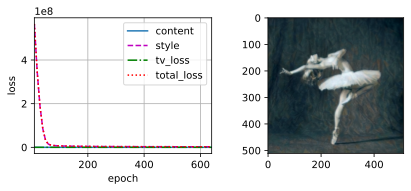

In [25]:
def train(style_img, raw_img, Y_styles, Y_contents, backbone, lr, epochs):
    target, optimizer = inits(raw_img, lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, 0.8)
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, epochs],
                            legend=['content', 'style', 'tv_loss', 'total_loss'], ncols=2, figsize=(7, 2.5))
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        Y_style_hat, Y_content_hat = extract_features(target, backbone, style_layers, content_layers)
        #print(len(Y_style_hat))
        sl, cl, tv_loss, total_loss = get_losses(target, Y_style_hat, Y_content_hat, Y_styles, Y_contents)
        #print(total_loss)
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(back_to_PIL(target))
            animator.add(
                epoch + 1,
                [float(sum(cl)),
                 float(sum(sl)),
                 float(tv_loss),
                 float(total_loss)
                ])
        
    return target
output = train(style_img, raw_img, Y_styles, Y_contents, backbone, 0.01, 640)